Markov state model for pentapeptide
=====


First we import pyemma and check what version we are using.

In [1]:
import pyemma
pyemma.__version__

'1.2.2-160-g2169310-dirty'

This notebook has been tested for the development version. If you are using a different version some adaptations may be required.

Now we import a few general packages, including basic numerics and algebra routines (numpy) and plotting routines (matplotlib), and makes sure that all plots are shown inside the notebook rather than in a separate window (nicer that way).

In [2]:
import os
%pylab inline
matplotlib.rcParams.update({'font.size': 12})

Populating the interactive namespace from numpy and matplotlib


Now we import the PyEMMA modules required for the following steps.

In [3]:
import pyemma.coordinates as coor
import pyemma.msm as msm
import pyemma.plots as mplt

In [4]:
def save_figure(name):
    # change these if wanted
    do_save = True
    fig_dir = '/Users/noe/data/papers/EMMA2/figs/penta_peptide/'
    if do_save:
        savefig(fig_dir + name, bbox_inches='tight')

In [5]:
def plot_sampled_function(xall, yall, zall, ax=None, nbins=100, nlevels=20, cmap=cm.bwr, cbar=True, cbar_label=None):
    # histogram data
    xmin = np.min(xall)
    xmax = np.max(xall)
    dx = (xmax - xmin) / float(nbins)
    ymin = np.min(yall)
    ymax = np.max(yall)
    dy = (ymax - ymin) / float(nbins)
    # bin data
    eps = x
    xbins = np.linspace(xmin - 0.5*dx, xmax + 0.5*dx, num=nbins)
    ybins = np.linspace(ymin - 0.5*dy, ymax + 0.5*dy, num=nbins)
    xI = np.digitize(xall, xbins)
    yI = np.digitize(yall, ybins)
    # result
    z = np.zeros((nbins, nbins))
    N = np.zeros((nbins, nbins))
    # average over bins
    for t in range(len(xall)):
        z[xI[t], yI[t]] += zall[t]
        N[xI[t], yI[t]] += 1.0
    z /= N
    # do a contour plot
    extent = [xmin, xmax, ymin, ymax]
    if ax is None:
        ax = gca()
    ax.contourf(z.T, 100, extent=extent, cmap=cmap)
    if cbar:
        cbar = plt.colorbar()
        if cbar_label is not None:
            cbar.ax.set_ylabel(cbar_label)
            
    return ax

In [6]:
def plot_sampled_density(xall, yall, zall, ax=None, nbins=100, cmap=cm.Blues, cbar=True, cbar_label=None):
    return plot_sampled_function(xall, yall, zall, ax=ax, nbins=nbins, cmap=cmap, cbar=cbar, cbar_label=cbar_label)

Load pentapeptide coordinates and select features
------

We first have to load the PDB file and the trajectory data, in this case for WW-pentapeptide.

In [7]:
indir = './data'
topfile =  indir+'/init-ww-penta.pdb'
traj_list = []
for filename in os.listdir(indir):
    if filename.endswith('-protein.xtc'):
        traj_list.append(os.path.join(indir,filename))

We can decide here which features we would like to use in the further analysis. In this case backbone torsions. As we want to do TICA on those coordinates, which requires subtracting the mean from each feature, we cannot use angles directly but have to transform them into a space where an arithmetic mean can be computed. We are using the cos/sin transform to do this, specified by the *cossin* option.

In [21]:
feat = coor.featurizer(topfile)
feat.add_backbone_torsions(cossin=True)
feat.add_chi1_torsions(cossin=True)
#feat.add_distances(feat.pairs(feat.select_Heavy()))
# describe the features
# feat.describe()

In [19]:
feat.dimension()

24

Now we define the source of input coordinates (we don't load them into memory at this stage - they will be loaded as needed). Compute a few basic data statistics gives:

In [22]:
inp = coor.source(traj_list, feat)
print 'number of trajectories = ',inp.number_of_trajectories()
print 'trajectory length = ',inp.trajectory_length(0)
print 'trajectory time step = ',500.0 / (inp.trajectory_length(0)-1),'ns'
print 'number of dimension = ',inp.dimension()

number of trajectories =  25
trajectory length =  5001
trajectory time step =  0.1 ns
number of dimension =  24


#TICA and clustering 

For TICA we have to choose a *lag* time and we have to define the output dimension. This can be either set by the *dim* keyword, or by specify a percentage the kinetic variance we want to keep. Here we choose 90%, which gives us three dimensions. From the original 16-dimensional space, most of the relevant kinetic information is in a four-dimensional subspace.

In [23]:
tica_obj = coor.tica(inp, lag=20, var_cutoff=0.9, kinetic_map=True)
print 'TICA dimension ', tica_obj.dimension()

TICA dimension  4


We can have a look at the cumulative kinetic variance, which is similar to the cumulative variance in PCA. Three dimensions explain 78% of the data, five dimensions 95%.

In [24]:
tica_obj.cumvar

array([ 0.28357727,  0.55658386,  0.77926984,  0.91711502,  0.95408678,
        0.97782248,  0.99388684,  0.998678  ,  0.99919249,  0.99933832,
        0.99946794,  0.99958734,  0.9996972 ,  0.99978629,  0.99984265,
        0.99988739,  0.99992208,  0.99994793,  0.99996797,  0.99998057,
        0.99999049,  0.99999835,  0.99999984,  1.        ])

In [25]:
# here we do a little trick to ensure that eigenvectors always have the same sign structure. 
# That's irrelevant to the analysis and just nicer plots - you can ignore it.
for i in range(2):
    if tica_obj.eigenvectors[0, i] > 0: 
        tica_obj.eigenvectors[:, i] *= -1

Now we get the TICA output, i.e. the coordinates after being transformed to the three slowest components. You can think of this as a low-dimensional space of good reaction coordinates. 
Having a look at the shape of the output reveals that we still have 25 trajectories, each of length 5001, but now only three dimensions.

In [26]:
Y = tica_obj.get_output() # get tica coordinates
print 'number of trajectories = ', np.shape(Y)[0]
print 'number of frames = ', np.shape(Y)[1]
print 'number of dimensions = ',np.shape(Y)[2]

number of trajectories =  25
number of frames =  5001
number of dimensions =  4


Note that at this point we loaded the compressed coordinates into memory. We don't have to do this, but it will significantly speed up any further analysis. It is also easy because it's low-dimensional. In general, after the TICA-transformation we can often keep the data in memory even if we are working with massive data of a large protein. 

Now we look at the distribution on the two dominant TICA coordinates (three are hard to visualize). For that, we build a histogram of the first two TICA dimensions and then compute a free energy by taking
$F_i = -\ln z_i$, where $z_i$ is the number of bin counts.

In [27]:
def plot_labels(ax=None):
    if ax is None:
        ax = gca()
    ax.text(-2, -4.7, '1', fontsize=20, color='black')
    ax.text(-1.2, -5, '2', fontsize=20, color='black')
    ax.text(-4.2, 1.5, '3', fontsize=20, color='black')
    ax.text(-0.1, 0, '4', fontsize=20, color='white')    

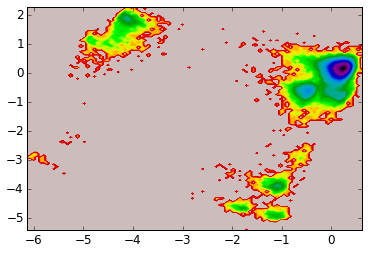

In [31]:
mplt.plot_free_energy(np.vstack(Y)[:,0], np.vstack(Y)[:,1], cbar=False)
# plot_labels()

Let's have a look how one of the trajectories looks like in the space of the first three TICA components. We can see that the TICA components nicely resolve the slow transitions as discrete jumps.

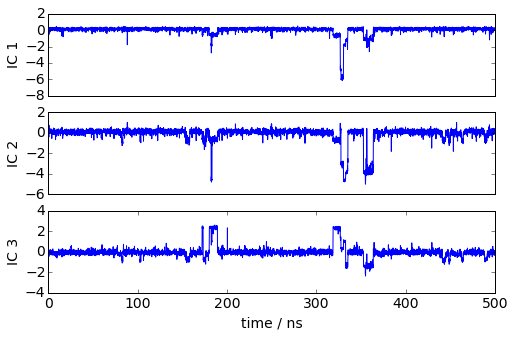

In [32]:
matplotlib.rcParams.update({'font.size': 14})
dt = 0.1
figure(figsize(8,5))
ax1=plt.subplot(311)
x = dt*np.arange(Y[0].shape[0])
plot(x, Y[0][:,0]); ylabel('IC 1'); xticks([]); yticks(np.arange(-8, 4, 2))
ax1=plt.subplot(312)
plot(x, Y[0][:,1]); ylabel('IC 2'); xticks([]);  yticks(np.arange(-6, 4, 2))
ax1=plt.subplot(313)
plot(x, Y[0][:,2]); xlabel('time / ns'); ylabel('IC 3'); yticks(np.arange(-4, 6, 2))
save_figure('ic_trajs.png')

The TICA coordinates are now clustered into a number of discrete states using the k-means algorithm. The k-means algorithm requires as input the number of clusters *n_clusters*. For the metric there is only one choice possible here which is *euclidean*.

In [33]:
n_clusters = 250      # number of k-means clusters

In [34]:
clustering = coor.cluster_kmeans(Y,k=n_clusters)

2015-08-07 00:12:33,962 coordinates.clustering.KmeansClustering[2] INFO     Algorithm did not reach convergence criterion of 1e-05 in 10 iterations. Consider increasing max_iter.


The trajectories are now assigned to the cluster centers.

In [35]:
dtrajs = clustering.dtrajs

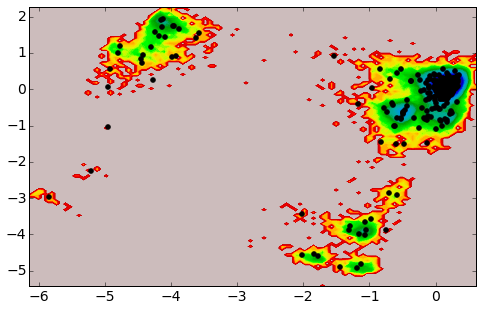

In [37]:
mplt.plot_free_energy(np.vstack(Y)[:,0], np.vstack(Y)[:,1], cbar=False)
cc_x = clustering.clustercenters[:,0]
cc_y = clustering.clustercenters[:,1]
plot(cc_x,cc_y, linewidth=0, marker='o', markersize=5, color='black')

The states are well distributed in phase space.

#Implied timescales

Here we calculate the implied timescales at a series of lagtimes defined in the *lags[ ]* array. Instead of an array you can just give a single number such as lags=100 in order to generate a range of lagtimes <= 100.

In [38]:
its = msm.timescales_msm(dtrajs, lags=200, nits=10)

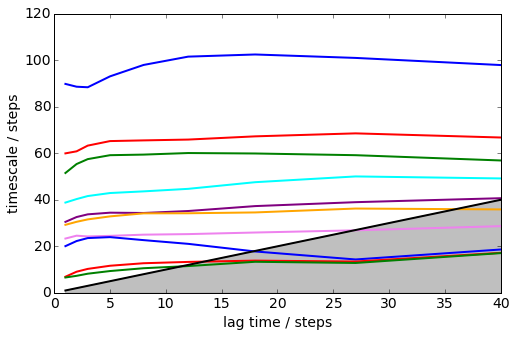

In [40]:
matplotlib.rcParams.update({'font.size': 14})
mplt.plot_implied_timescales(its, ylog=False, units='steps', linewidth=2)
xlim(0, 40); ylim(0, 120);

Error bars for the implied timescales can be obtained by bootstrapping.

In [41]:
its = msm.timescales_msm(dtrajs, lags=100, nits=10, errors='bayes')

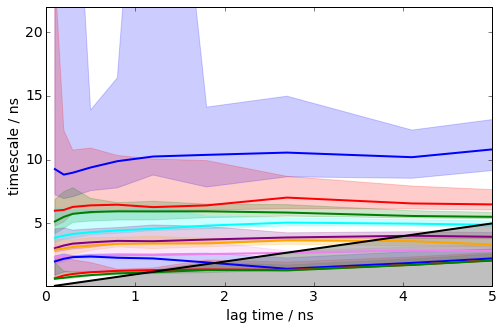

In [42]:
figure(figsize(8,5))
matplotlib.rcParams.update({'font.size': 14})
mplt.plot_implied_timescales(its, show_mean=False, ylog=False, dt=0.1, units='ns', linewidth=2)
xlim(0, 5); ylim(0.1,22);
save_figure('its.png')

It can be seen that the timescales are approximately constant within the error. Below we will select a lag time of 20 ns to build a Markov model.

Estimate MSM
===========

The lagtime to estimate the Markov model is specified as *msm_lag* here. 

In [44]:
msm_lag = 12
M = msm.estimate_markov_model(dtrajs, msm_lag)
print 'fraction of states used = ', M.active_state_fraction
print 'fraction of counts used = ', M.active_count_fraction

fraction of states used =  1.0
fraction of counts used =  1.0


In [45]:
# test MSM
M = msm.bayesian_markov_model(dtrajs, msm_lag)

In [46]:
ck = M.cktest(4, mlags=11, err_est=False)

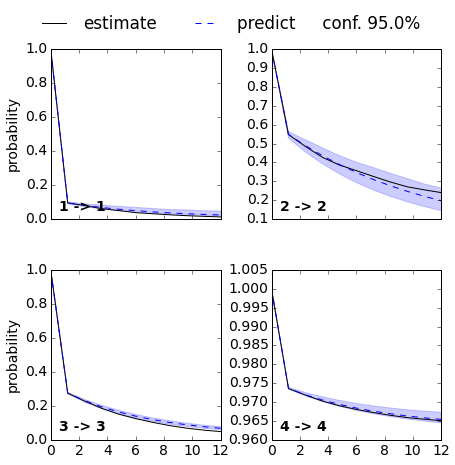

In [30]:
matplotlib.rcParams.update({'font.size': 14})
mpl.plot_cktest(ck, diag=True, figsize=(7,7), layout=(2,2), padding_top=0.1, y01=False, padding_between=0.3, dt=0.1, units='ns')
save_figure('cktest.png')

From the MSM which is now stored in the object we called *M* various properties can be obtained. We start by analyzing the free energy computed over the first two TICA coordinates

In [49]:
# ... therefore we take the statistical weight of each simulation timestep (also available from the MSM object)
# and use that to create a contour plot
xall = np.vstack(Y)[:,0]
yall = np.vstack(Y)[:,1]
W = np.concatenate(M.trajectory_weights())

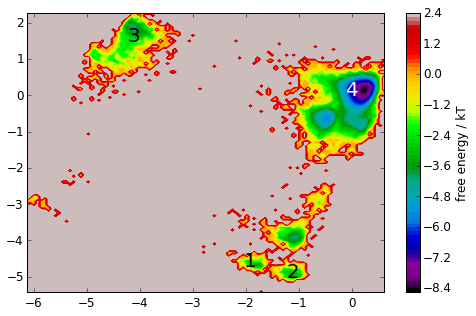

In [32]:
# TODO: make this an MSM-weighted free energy plot
matplotlib.rcParams.update({'font.size': 12})
plot_free_energy(xall, yall)
plot_labels()
save_figure('free_energy_msm.png')

Now we analyze the slowest processes by looking at the distribution of states along the first 3 eigenvectors.

In [33]:
# project eigenvectors
proj_ev_all = [np.hstack([M.eigenvectors_right()[:,i][dtraj] for dtraj in M.discrete_trajectories_full]) 
               for i in range(10)]

/Users/noe/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:22: RuntimeWarning: invalid value encountered in divide


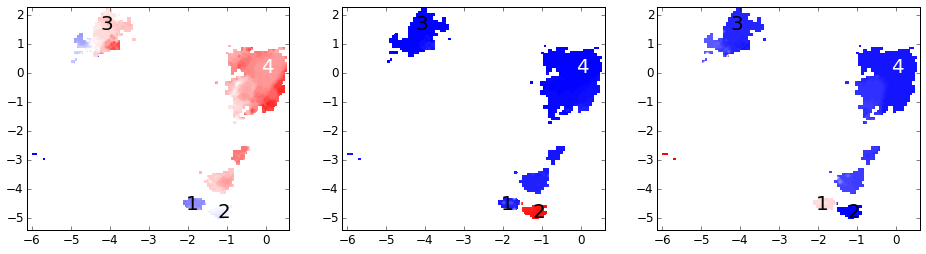

In [34]:
fig, axes = subplots(1, 3, figsize=(16,4))
for i, ax in enumerate(axes):
    plot_sampled_function(xall, yall, proj_ev_all[i], ax=ax, cbar=False)
    plot_labels(ax)
save_figure('eigenvectors.png')

PCCA
==

Next the MSM is coarse grained into a user-defined number of macrostates (*n_sets*).

In [47]:
n_sets = 4
M.pcca(n_sets)
pcca_dist = M.metastable_distributions
membership = M.metastable_memberships  # get PCCA memberships
# memberships over trajectory
dist_all = [np.hstack([pcca_dist[i,:][dtraj] for dtraj in M.discrete_trajectories_full]) for i in range(n_sets)]
mem_all = [np.hstack([membership[:,i][dtraj] for dtraj in M.discrete_trajectories_full]) for i in range(n_sets)]

We have now determined the probability for each microstate to belong to a given macrostate. These probabilities are called *memberships* to a given macrostate.

/Users/noe/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:22: RuntimeWarning: invalid value encountered in divide


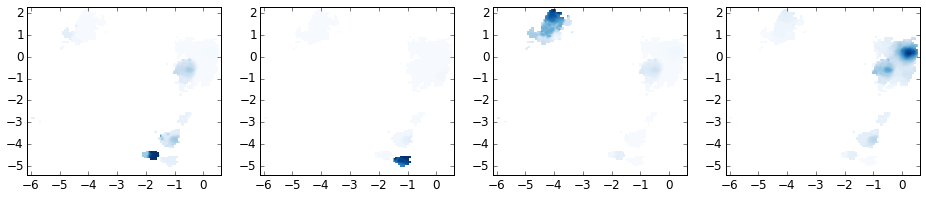

In [50]:
fig, axes = subplots(1, 4, figsize=(16, 3))
matplotlib.rcParams.update({'font.size': 12})
axes = axes.flatten()
for k in range(n_sets):
    plot_sampled_density(xall, yall, dist_all[k], ax=axes[k], cmap=cm.Blues, cbar=False)
save_figure('pcca_distributions.png')    

For each macrostate we can generate a number of representative sample structures and store them into a trajectory file.

In [51]:
pcca_samples = M.sample_by_distributions(pcca_dist, 10)

In [53]:
coor.save_trajs(inp, pcca_samples, outfiles=['./data/pcca1_10samples.xtc','./data/pcca2_10samples.xtc',
                                             './data/pcca3_10samples.xtc','./data/pcca4_10samples.xtc'])

2015-08-07 00:36:07,949 coordinates.api INFO     Created file ./data/pcca1_10samples.xtc
2015-08-07 00:36:08,123 coordinates.api INFO     Created file ./data/pcca2_10samples.xtc
2015-08-07 00:36:08,542 coordinates.api INFO     Created file ./data/pcca3_10samples.xtc
2015-08-07 00:36:08,988 coordinates.api INFO     Created file ./data/pcca4_10samples.xtc


['./data/pcca1_10samples.xtc',
 './data/pcca2_10samples.xtc',
 './data/pcca3_10samples.xtc',
 './data/pcca4_10samples.xtc']

Structure figures are generated with VMD, pyMol or another visualization program of your choice. Here we used VMD to generate the following structures, corresponding to the four metastable states:

In [103]:
#from IPython.display import Image
#Image(filename='./data/pcca4_sets.png', width=800)

<table>
<tr>
<td>PCCA state 1</td>
<td>PCCA state 2</td>
<td>PCCA state 3</td>
<td>PCCA state 4</td>
</tr>
<tr>
<td>
<img src='./data/pcca1_10samples.png', width=200>
</td>
<td>
<img src='./data/pcca2_10samples.png', width=200>
</td>
<td>
<img src='./data/pcca3_10samples.png', width=200>
</td>
<td>
<img src='./data/pcca4_10samples.png', width=200>
</td>
</tr>
</table>

Coarse-grained kinetic Model using a Hidden Markov Model
------

In [61]:
hmm = M.coarse_grain(4)

2015-08-07 00:42:55,962 MaximumLikelihoodHMSM[0x10cc2dfd0] WARNING  Requested coarse-grained model with 4 metastable states at lag=12.The ratio of relaxation timescales between 4 and 5 states is only 1.29767629813 while we recommend at least 2.  It is possible that the resulting HMM is inaccurate. Handle with caution.


In [62]:
hmm.stationary_distribution

array([ 0.05750594,  0.12163436,  0.0203132 ,  0.8005465 ])

In [63]:
hmm.transition_matrix

array([[ 0.80833581,  0.01789579,  0.00549565,  0.16827275],
       [ 0.00846072,  0.70561458,  0.0018806 ,  0.2840441 ],
       [ 0.01555798,  0.01126095,  0.83003519,  0.14314588],
       [ 0.0120876 ,  0.04315742,  0.00363221,  0.94112278]])

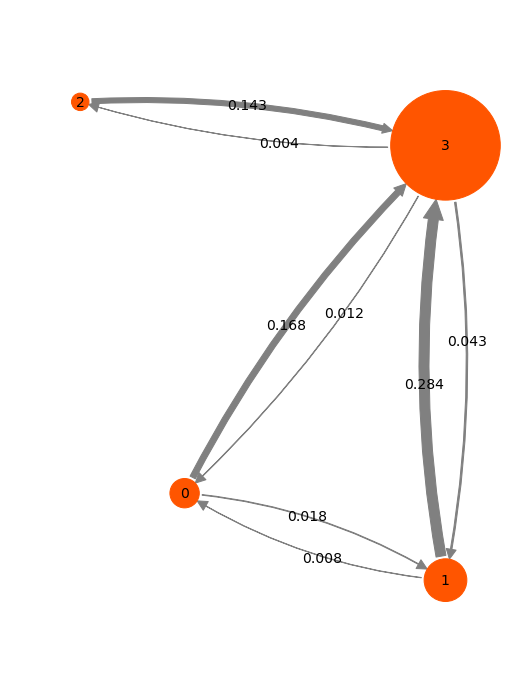

In [66]:
pos=np.array([[-3, -4], [0, -5], [-4.2, 0.5], [0, 0]])    
mplt.plot_markov_model(hmm, pos=pos, minflux=4e-4, arrow_label_format='%.3f')
gca().set_frame_on(False)
save_figure('network.png')

In [ ]:
msm.bayesian_hidden_markov_model

In [58]:
# sampling
from pyemma.msm import BayesianHMSM
BHMM = BayesianHMSM(nstates=4, lag=10, prior='mixed', nsamples=100000, conf=0.99)
BHMM.estimate(dtrajs)

2015-08-04 21:26:09,493 MaximumLikelihoodHMSM[0x1108e0750] WARNING  Requested coarse-grained model with 4 metastable states at lag=10.The ratio of relaxation timescales between 4 and 5 states is only 1.36558104499 while we recommend at least 2.  It is possible that the resulting HMM is inaccurate. Handle with caution.


BayesianHMSM(conf=0.95, connectivity='largest', dt_traj='1 step',
       init_hmsm=None, lag=10, nsamples=100000, nstates=4,
       observe_active=True, prior='mixed', reversible=True,
       stride='effective')

In [59]:
BHMM.transition_matrix

array([[ 0.92930887,  0.0326272 ,  0.01057372,  0.02749021],
       [ 0.09429331,  0.76544752,  0.00587172,  0.13438744],
       [ 0.05968792,  0.01146894,  0.85580809,  0.07303505],
       [ 0.02565449,  0.04339532,  0.01207419,  0.918876  ]])

In [60]:
BHMM.sample_conf('transition_matrix')

(array([[  2.51549414e-01,   5.10046700e-03,   3.56133323e-03,
           1.97423357e-03],
        [  9.12011199e-04,   7.20881955e-01,   2.73572633e-05,
           1.36863223e-03],
        [  1.23216627e-03,   4.76390062e-05,   8.35005297e-01,
           1.67024792e-03],
        [  1.36899937e-03,   1.07255791e-02,   6.88444692e-03,
           3.10275081e-01]]),
 array([[ 0.9477878 ,  0.04859516,  0.02947989,  0.70502832],
        [ 0.25434037,  0.79704695,  0.0083123 ,  0.26731968],
        [ 0.15100839,  0.01487193,  0.88714273,  0.14973934],
        [ 0.63072137,  0.0523646 ,  0.01845517,  0.95278415]]))

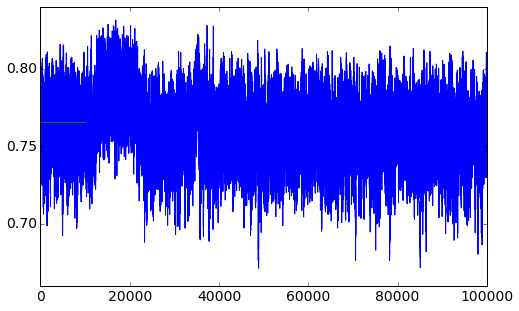

In [68]:
i = 1
plot(np.array(BHMM.sample_f('transition_matrix'))[:, i, i])
pii = BHMM.transition_matrix[i, i]
plot([0, 10000], [pii, pii])

In [45]:
L, R = BHMM.sample_conf('transition_matrix')

In [46]:
R - L

array([[ 0.09140316,  0.01525592,  0.0077084 ,  0.07483846],
       [ 0.0082421 ,  0.0433083 ,  0.00264084,  0.03862965],
       [ 0.02493839,  0.01811615,  0.07972582,  0.07370696],
       [ 0.00851513,  0.00856721,  0.00228851,  0.01531006]])